# Weather pattern forecasting with LSTM

- **Problem statement:** Forecast the next day's average temperature using the multivariate weather history from Kaggle (`thedevastator/weather-prediction`). The model answers: *given the last 30 days of weather, what should we expect tomorrow's temperature to be?*
- **Significance:** Better short-term forecasts improve planning for agriculture, energy demand, logistics, and safety. A sequence model (LSTM) can leverage temporal patterns and seasonality that simple regressions miss.
- **Plan:** Load the Kaggle dataset via `kagglehub`, explore structure/quality, build an LSTM for regression, evaluate with MAE/RMSE, and note future improvements.


In [19]:
from pathlib import Path
import os
import warnings

import kagglehub
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU devices detected:", tf.config.list_physical_devices("GPU"))


TensorFlow version: 2.16.1
GPU devices detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load dataset
Download the Kaggle dataset with `kagglehub` and inspect the raw file(s). The helper below picks the first CSV found in the download directory so the notebook is resilient to small packaging changes.


In [20]:
# Download and read the dataset
DATASET_SLUG = "thedevastator/weather-prediction"

data_dir = Path(kagglehub.dataset_download(DATASET_SLUG))
csv_files = list(data_dir.rglob("*.csv"))
if not csv_files:
    raise FileNotFoundError("No CSV files found in the downloaded dataset.")

csv_path = csv_files[0]
print(f"Using file: {csv_path}")

df = pd.read_csv(csv_path)
df_raw = df.copy()
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Using file: /Users/sebastian/.cache/kagglehub/datasets/thedevastator/weather-prediction/versions/2/weather_prediction_dataset.csv
Shape: (3654, 165)
Columns: ['DATE', 'MONTH', 'BASEL_cloud_cover', 'BASEL_humidity', 'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_precipitation', 'BASEL_sunshine', 'BASEL_temp_mean', 'BASEL_temp_min', 'BASEL_temp_max', 'BUDAPEST_cloud_cover', 'BUDAPEST_humidity', 'BUDAPEST_pressure', 'BUDAPEST_global_radiation', 'BUDAPEST_precipitation', 'BUDAPEST_sunshine', 'BUDAPEST_temp_mean', 'BUDAPEST_temp_max', 'DE_BILT_cloud_cover', 'DE_BILT_wind_speed', 'DE_BILT_wind_gust', 'DE_BILT_humidity', 'DE_BILT_pressure', 'DE_BILT_global_radiation', 'DE_BILT_precipitation', 'DE_BILT_sunshine', 'DE_BILT_temp_mean', 'DE_BILT_temp_min', 'DE_BILT_temp_max', 'DRESDEN_cloud_cover', 'DRESDEN_wind_speed', 'DRESDEN_wind_gust', 'DRESDEN_humidity', 'DRESDEN_global_radiation', 'DRESDEN_precipitation', 'DRESDEN_sunshine', 'DRESDEN_temp_mean', 'DRESDEN_temp_min', 'DRESDEN_temp_max', 

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


## Quick exploratory data analysis (EDA)
Check structure, missingness, and basic distributions to understand modeling choices and any cleanup required.


In [21]:
# Basic structure and missingness overview
print("Data types and non-null counts:")
info = df.info()

print("\nMissing values (top 10):")
missing = df.isnull().sum().sort_values(ascending=False)
display(missing.head(10))
print("All values present in the dataset")

print("\nSummary stats (numerical):")
display(df.describe().T)


Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Columns: 165 entries, DATE to TOURS_temp_max
dtypes: float64(150), int64(15)
memory usage: 4.6 MB

Missing values (top 10):


DATE                         0
MUENCHEN_cloud_cover         0
MUENCHEN_wind_gust           0
MUENCHEN_humidity            0
MUENCHEN_pressure            0
MUENCHEN_global_radiation    0
MUENCHEN_precipitation       0
MUENCHEN_sunshine            0
MUENCHEN_temp_mean           0
MUENCHEN_temp_min            0
dtype: int64

All values present in the dataset

Summary stats (numerical):


,count,mean,std,min,25%,50%,75%,max
DATE,3654.0,2.004568e+07,28742.871733,2.000010e+07,2.002070e+07,2.004567e+07,2.007070e+07,2.010010e+07
MONTH,3654.0,6.520799e+00,3.450083,1.000000e+00,4.000000e+00,7.000000e+00,1.000000e+01,1.200000e+01
BASEL_cloud_cover,3654.0,5.418446e+00,2.325497,0.000000e+00,4.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00
BASEL_humidity,3654.0,7.451067e-01,0.107788,3.800000e-01,6.700000e-01,7.600000e-01,8.300000e-01,9.800000e-01
BASEL_pressure,3654.0,1.017876e+00,0.007962,9.856000e-01,1.013300e+00,1.017700e+00,1.022700e+00,1.040800e+00
...,...,...,...,...,...,...,...,...
TOURS_global_radiation,3654.0,1.369787e+00,0.926472,5.000000e-02,5.500000e-01,1.235000e+00,2.090000e+00,3.560000e+00
TOURS_precipitation,3654.0,1.861002e-01,0.422151,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e-01,6.200000e+00
TOURS_temp_mean,3654.0,1.220580e+01,6.467155,-6.200000e+00,7.600000e+00,1.230000e+01,1.720000e+01,3.120000e+01
TOURS_temp_min,3654.0,7.860536e+00,5.692256,-1.300000e+01,3.700000e+00,8.300000e+00,1.230000e+01,2.260000e+01


## Target selection and preprocessing
- Detect a date column (if present) to preserve chronological order.
- Auto-pick a temperature-like target; if none found, fall back to the first numeric column.
- Clean missing values (interpolation for numeric, mode for categorical) and one-hot encode categoricals.
- Scale features/target and build sliding windows for the LSTM (30-day lookback).


In [22]:
WINDOW = 30  # days of lookback for each prediction

# Identify date column
potential_date_cols = [c for c in df.columns if "date" in c.lower()]
date_col = potential_date_cols[0] if potential_date_cols else None

# Select a temperature-like target
candidate_keys = ["temp", "temperature", "tavg", "avg_temp", "mean_temp"]
target_col = None
for col in df.columns:
    if any(key in col.lower() for key in candidate_keys):
        target_col = col
        break
if target_col is None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        raise ValueError("No numeric column available to use as target.")
    target_col = numeric_cols[0]

print(f"Using target column: {target_col}")
if date_col:
    print(f"Date column detected: {date_col}")

# Work on a copy to keep raw data intact
df_work = df.copy()

# Parse and sort by date if present
if date_col:
    df_work[date_col] = pd.to_datetime(df_work[date_col], errors="coerce")
    df_work = df_work.dropna(subset=[date_col])
    df_work = df_work.sort_values(date_col)
else:
    df_work = df_work.sort_index()

# Ensure target is numeric
if not np.issubdtype(df_work[target_col].dtype, np.number):
    df_work[target_col] = pd.to_numeric(df_work[target_col], errors="coerce")

# Handle missing values
numeric_cols = df_work.select_dtypes(include=[np.number]).columns
categorical_cols = df_work.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
categorical_cols = [c for c in categorical_cols if c != target_col and c != date_col]

df_work[numeric_cols] = df_work[numeric_cols].interpolate(limit_direction="both")
df_work[numeric_cols] = df_work[numeric_cols].fillna(df_work[numeric_cols].median())
for col in categorical_cols:
    df_work[col] = df_work[col].fillna(df_work[col].mode().iloc[0])

# Keep a date index for plotting later
if date_col:
    date_index = df_work[date_col].reset_index(drop=True)
else:
    date_index = pd.RangeIndex(len(df_work))

# Prepare model matrix
model_df = df_work.copy()
if date_col and date_col in model_df.columns:
    model_df = model_df.drop(columns=[date_col])

model_df = pd.get_dummies(model_df, columns=categorical_cols, drop_first=True)
model_df = model_df.dropna(subset=[target_col])

y = model_df[target_col].values
X = model_df.drop(columns=[target_col]).values

feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)

target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1)).flatten()


def create_sequences(features: np.ndarray, target: np.ndarray, window: int):
    Xs, ys = [], []
    for i in range(window, len(features)):
        Xs.append(features[i - window : i])
        ys.append(target[i])
    return np.array(Xs), np.array(ys)


X_seq, y_seq = create_sequences(X_scaled, y_scaled, window=WINDOW)

split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

if date_col:
    date_seq = date_index.iloc[WINDOW:].reset_index(drop=True)
else:
    date_seq = pd.RangeIndex(len(y_seq))
date_test = date_seq[split_idx:]

print(f"Features after encoding: {X.shape[1]}")
print(f"Train sequences: {X_train.shape}, Test sequences: {X_test.shape}")


Using target column: BASEL_temp_mean
Date column detected: DATE
Features after encoding: 163
Train sequences: (2899, 30, 163), Test sequences: (725, 30, 163)


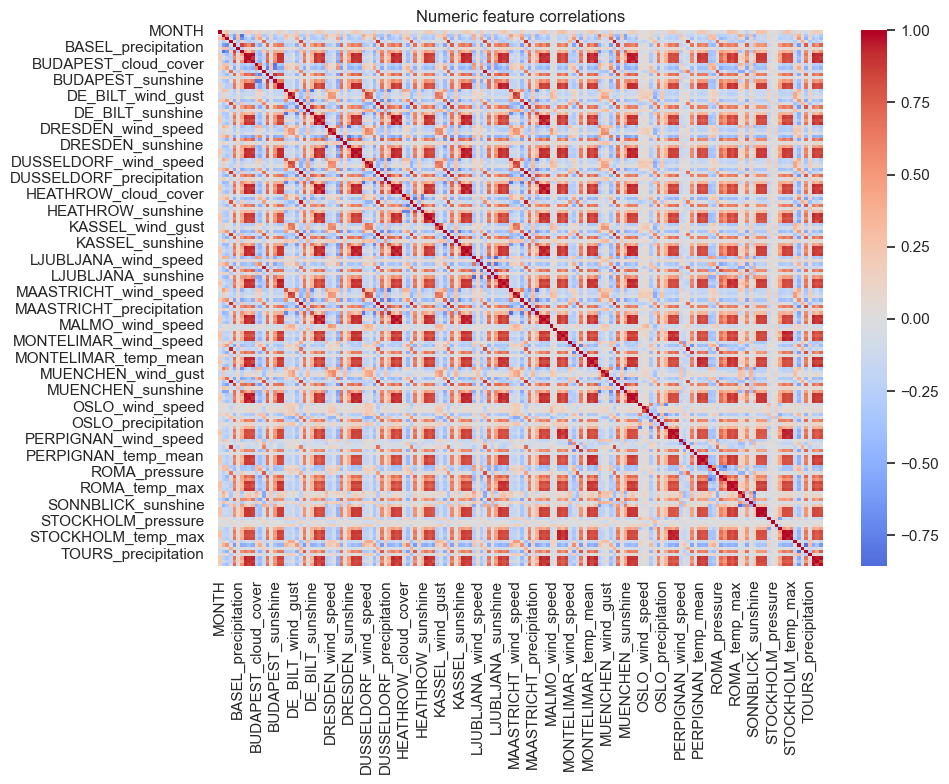

In [23]:
plt.figure(figsize=(10, 8))
correlation_matrix = df_work.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0)
plt.title("Numeric feature correlations")
plt.tight_layout()
plt.show()


## Build and train the LSTM model
We use a two-layer LSTM to capture temporal patterns with early stopping to prevent overfitting. Loss: MSE; metrics: MAE for interpretability.


Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.1789 - mae: 0.3280 - val_loss: 0.1360 - val_mae: 0.3020
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0941 - mae: 0.2421 - val_loss: 0.1067 - val_mae: 0.2646
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0749 - mae: 0.2154 - val_loss: 0.0972 - val_mae: 0.2474
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0621 - mae: 0.1957 - val_loss: 0.0953 - val_mae: 0.2446
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0543 - mae: 0.1819 - val_loss: 0.0905 - val_mae: 0.2366
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0495 - mae: 0.1734 - val_loss: 0.0837 - val_mae: 0.2262
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0458 - mae: 0.1681 - val_loss: 0.0790 - val_mae: 0.2199
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0422 - mae: 0.1616 - val_loss: 0.0787 - val_mae: 0.2195
Epoch 9/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.039

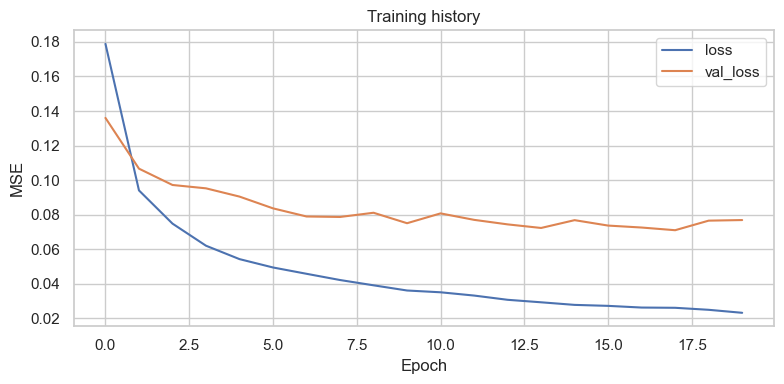

In [24]:
# Define the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="mse",
              metrics=["mae"])

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

history_df = pd.DataFrame(history.history)
plt.figure(figsize=(8, 4))
plt.plot(history_df["loss"], label="loss")
plt.plot(history_df["val_loss"], label="val_loss")
plt.title("Training history")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()

## Evaluate and visualize predictions
Compute MAE/RMSE on the test window and plot actual vs predicted temperatures.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
{'MAE': 1.5605937410367268, 'RMSE': 1.9632990482754993, 'R2': 0.9284497825218481}


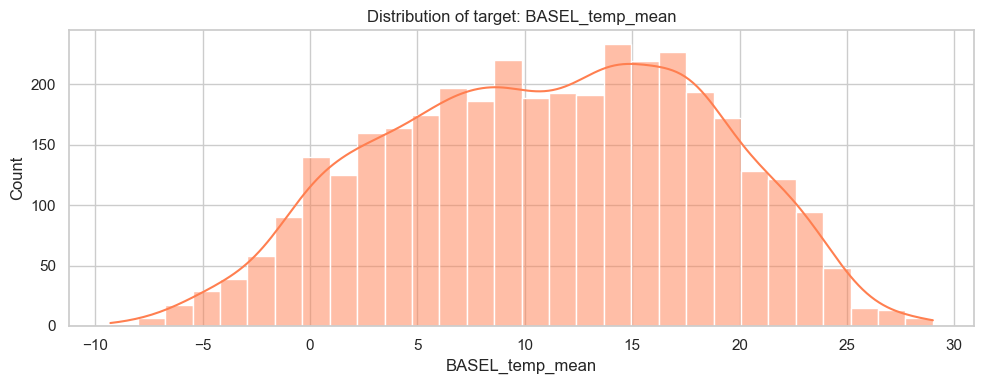

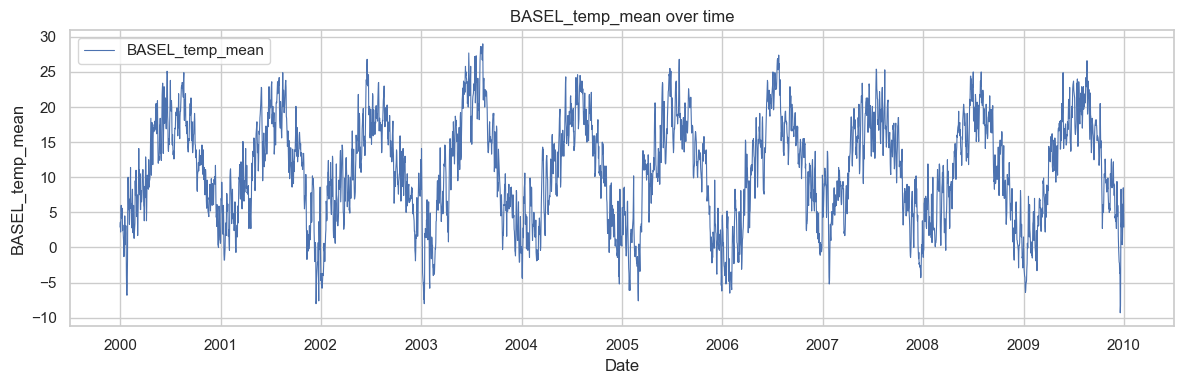

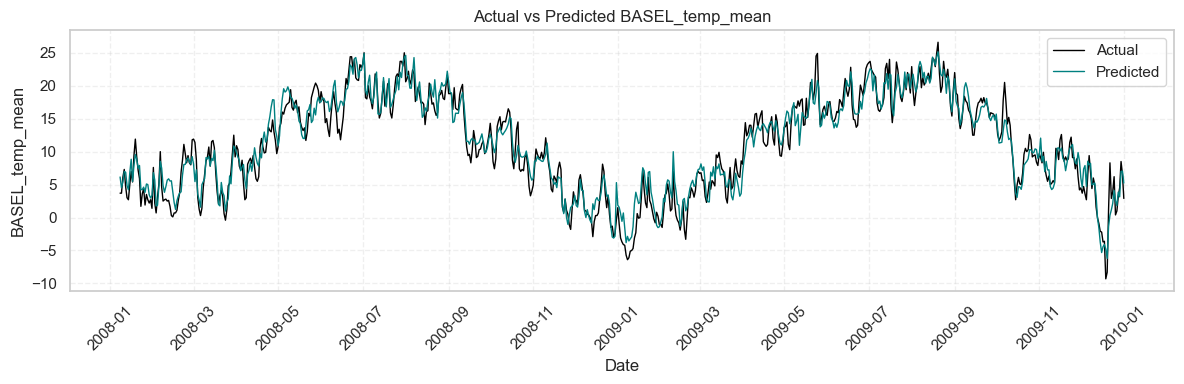

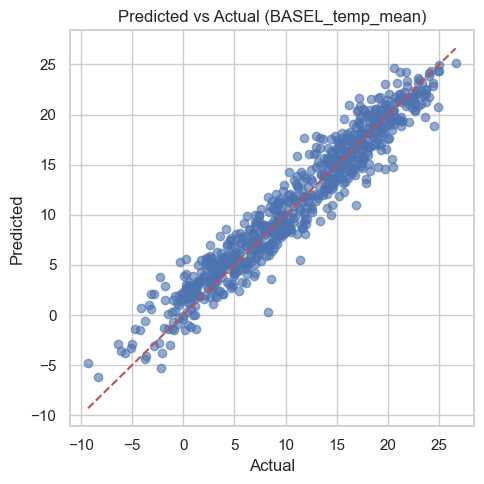

In [25]:
# Predict on the hold-out set and invert scaling
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()
y_true = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_true, y_pred)
try:
    rmse = mean_squared_error(y_true, y_pred, squared=False)
except TypeError:  # compatibility with older scikit-learn
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print({"MAE": mae, "RMSE": rmse, "R2": r2})

# Time series plot with proper date formatting
plt.figure(figsize=(10, 4))
sns.histplot(df[target_col], bins=30, kde=True, color="coral")
plt.title(f"Distribution of target: {target_col}")
plt.xlabel(target_col)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Time series with proper date formatting
fig, ax = plt.subplots(figsize=(12, 4))
if date_col in df.columns:
    date_vals = pd.to_datetime(df[date_col], format="%Y%m%d", errors="coerce")
    ax.plot(date_vals, df[target_col], label=target_col, linewidth=0.8)
    ax.set_xlabel("Date")
    # Format dates as year (e.g., 2008)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=6))
else:
    ax.plot(df[target_col].reset_index(drop=True), label=target_col, linewidth=0.8)
    ax.set_xlabel("Observation index")
ax.set_ylabel(target_col)
ax.set_title(f"{target_col} over time")
ax.legend()
plt.tight_layout()
plt.show()

# Actual vs Predicted BASEL_temp_mean
fig, ax = plt.subplots(figsize=(12, 4))
# Reconstruct test_dates from original dataframe using same approach as plot above
if date_col:
    # Get the test set dates: start from WINDOW + split_idx in the original df
    test_start_idx = WINDOW + split_idx
    test_end_idx = test_start_idx + len(y_true)
    test_dates = pd.to_datetime(df[date_col].iloc[test_start_idx:test_end_idx], format="%Y%m%d", errors="coerce").reset_index(drop=True)
else:
    test_dates = pd.RangeIndex(len(y_true))
ax.plot(test_dates, y_true, label="Actual", color="black", linewidth=1)
ax.plot(test_dates, y_pred, label="Predicted", color="teal", linewidth=1)
ax.set_title(f"Actual vs Predicted {target_col}")
ax.set_xlabel("Date")
ax.set_ylabel(target_col)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.grid(alpha=0.3, linestyle="--")
ax.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, alpha=0.6)
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.xlabel(f"Actual")
plt.ylabel(f"Predicted")
plt.title(f"Predicted vs Actual ({target_col})")
plt.tight_layout()
plt.show()

## Opportunities for improvement
- Tune lookback window, hidden sizes, and learning rate; consider 1D CNN + LSTM hybrids.
- Try exogenous features (holiday flags, lagged precipitation) and seasonality decompositions.
- Perform rolling-origin evaluation instead of a single train/test split for more robust error estimates.
- Add probabilistic forecasts (MC dropout or quantile loss) to capture uncertainty.
- If dataset grows, consider `tf.data` pipelines and mixed precision (`tf.keras.mixed_precision.set_global_policy('mixed_float16')`) to speed training on Apple Silicon.


## LSTM with Horizon Predictions (t+1 and t+7)
Run LSTM predictions for both 1-day ahead (t+1) and 7-day ahead (t+7) forecasts for Basel to compare prediction quality at different time horizons. Uses same color scheme and axis labels as FFNN notebook for consistency.

In [26]:
# Helper functions for horizon-based LSTM predictions
# Color scheme consistent with FFNN notebook: black=Actual, teal=Predicted, coral=histogram

def plot_target_eda(df, target_col, date_col="DATE"):
    """
    Plot distribution and time series of a target variable (same day, for context).
    Uses same color scheme as FFNN notebook.
    """
    plt.figure(figsize=(10, 4))
    sns.histplot(df[target_col], bins=30, kde=True, color="coral")
    plt.title(f"Distribution of target: {target_col}")
    plt.xlabel(target_col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Time series with proper date formatting
    fig, ax = plt.subplots(figsize=(12, 4))
    if date_col in df.columns:
        date_vals = pd.to_datetime(df[date_col], format="%Y%m%d", errors="coerce")
        ax.plot(date_vals, df[target_col], label=target_col, linewidth=0.8)
        ax.set_xlabel("Date")
        # Format dates as year (e.g., 2008)
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=6))
    else:
        ax.plot(df[target_col].reset_index(drop=True), label=target_col, linewidth=0.8)
        ax.set_xlabel("Observation index")
    ax.set_ylabel(target_col)
    ax.set_title(f"{target_col} over time")
    ax.legend()
    plt.tight_layout()
    plt.show()


def prepare_lstm_data_horizon(df, target_col, horizon_days=1, window=30, date_col="DATE", test_size=0.2):
    """
    Prepares features and target for an LSTM that predicts temperature H days ahead.
    
    For each sequence of 'window' days:
      features = weather features for days [t-window+1, ..., t]
      target   = target_col on day t + horizon_days
    
    horizon_days: how many days into the future you want to predict (e.g., 1 or 7).
    """
    work = df.copy()
    
    # Parse date and sort chronologically
    if date_col in work.columns:
        work[date_col] = pd.to_datetime(work[date_col], format="%Y%m%d", errors="coerce")
        work = work.dropna(subset=[date_col])
        work = work.sort_values(date_col)
    else:
        work = work.sort_index()
    
    # Keep date index for later
    if date_col in work.columns:
        date_index = work[date_col].reset_index(drop=True)
    else:
        date_index = pd.RangeIndex(len(work))
    
    # Ensure target is numeric
    work[target_col] = pd.to_numeric(work[target_col], errors="coerce")
    
    # Handle missing values
    numeric_cols = work.select_dtypes(include=[np.number]).columns
    cat_cols = work.select_dtypes(include=["object", "category", "bool"]).columns
    cat_cols = [c for c in cat_cols if c != target_col and c != date_col]
    
    work[numeric_cols] = work[numeric_cols].interpolate(limit_direction="both")
    work[numeric_cols] = work[numeric_cols].fillna(work[numeric_cols].median())
    
    for col in cat_cols:
        work[col] = work[col].fillna(work[col].mode().iloc[0])
    
    # Build model frame: drop date column from features
    model_df = work.copy()
    if date_col in model_df.columns:
        model_df = model_df.drop(columns=[date_col])
    
    # One hot encode categorical features
    model_df = pd.get_dummies(model_df, columns=cat_cols, drop_first=True)
    
    # Separate features and target
    y_full = model_df[target_col].values.astype("float32")
    X_full = model_df.drop(columns=[target_col]).values.astype("float32")
    
    # Scale features and target
    feature_scaler = StandardScaler()
    X_scaled = feature_scaler.fit_transform(X_full)
    
    target_scaler = StandardScaler()
    y_scaled = target_scaler.fit_transform(y_full.reshape(-1, 1)).flatten()
    
    # Create sequences with horizon offset
    def create_sequences_horizon(features, target, window, horizon):
        Xs, ys = [], []
        for i in range(window, len(features) - horizon):
            Xs.append(features[i - window:i])
            ys.append(target[i + horizon])
        return np.array(Xs), np.array(ys)
    
    X_seq, y_seq = create_sequences_horizon(X_scaled, y_scaled, window, horizon_days)
    
    # Time-based train/test split
    n = len(X_seq)
    split_idx = int(n * (1 - test_size))
    
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
    
    # Dates for test set (adjusted for window and horizon)
    date_seq = date_index.iloc[window + horizon_days:].reset_index(drop=True)
    date_test = date_seq.iloc[split_idx:split_idx + len(y_test)]
    
    print(f"Target (t + {horizon_days} days of): {target_col}")
    print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
    print(f"Sequence shape: {X_train.shape[1:]}")
    
    return {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "date_test": date_test,
        "target_scaler": target_scaler,
        "feature_scaler": feature_scaler,
    }


def build_lstm(input_shape):
    """
    Build LSTM model for regression.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model


def plot_training_history(history, horizon_days):
    """Plot training history - consistent with FFNN notebook."""
    history_df = pd.DataFrame(history.history)
    plt.figure(figsize=(8, 4))
    plt.plot(history_df["loss"], label="loss")
    plt.plot(history_df["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title(f"Training history (LSTM, t + {horizon_days} days)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_predictions(date_test, y_true, y_pred, target_col, horizon_days):
    """
    Plot predictions vs actual - consistent color scheme with FFNN notebook.
    Actual: black, Predicted: teal
    """
    # Time series plot with proper date formatting
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(date_test, y_true, label=f"Actual (t + {horizon_days})", color="black", linewidth=1)
    ax.plot(date_test, y_pred, label=f"Predicted (t + {horizon_days})", color="teal", linewidth=1)
    ax.set_title(f"Actual vs Predicted {target_col} (t + {horizon_days} days)")
    ax.set_xlabel("Date")
    ax.set_ylabel(target_col)
    # Format dates as year-month (e.g., 2008-10) for test period
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # Scatter plot
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.6)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--")
    plt.xlabel(f"Actual (t + {horizon_days})")
    plt.ylabel(f"Predicted (t + {horizon_days})")
    plt.title(f"Predicted vs Actual (t + {horizon_days}) ({target_col})")
    plt.tight_layout()
    plt.show()


def run_lstm_for_target_horizon(df, target_col, horizon_days=1, window=30, date_col="DATE"):
    """
    Complete pipeline for running LSTM regression for a target at a given horizon.
    """
    print("=" * 80)
    print(f"Running LSTM regression for {target_col} at t + {horizon_days} days")
    print("=" * 80)
    
    # Basic EDA plots
    plot_target_eda(df, target_col, date_col=date_col)
    
    # Prepare data
    data = prepare_lstm_data_horizon(
        df,
        target_col=target_col,
        horizon_days=horizon_days,
        window=window,
        date_col=date_col,
        test_size=0.2,
    )
    
    X_train = data["X_train"]
    X_test = data["X_test"]
    y_train = data["y_train"]
    y_test = data["y_test"]
    date_test = data["date_test"]
    target_scaler = data["target_scaler"]
    
    # Build model
    model = build_lstm(X_train.shape[1:])
    model.summary()
    
    # Early stopping
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True
        )
    ]
    
    # Train
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=20,
        batch_size=32,
        shuffle=False,
        callbacks=callbacks,
        verbose=1
    )
    
    # Plot training history
    plot_training_history(history, horizon_days)
    
    # Predict and inverse scale
    y_pred_scaled = model.predict(X_test).flatten()
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    # Metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"\nResults for {target_col} at t + {horizon_days} days:")
    print(f"  MAE  = {mae:.3f}")
    print(f"  RMSE = {rmse:.3f}")
    print(f"  R^2  = {r2:.4f}")
    
    # Plot predictions
    plot_predictions(date_test, y_true, y_pred, target_col, horizon_days)
    
    return {
        "model": model,
        "history": history,
        "metrics": {"MAE": mae, "RMSE": rmse, "R2": r2},
        "y_test": y_true,
        "y_pred": y_pred,
        "date_test": date_test,
    }

print("Helper functions defined successfully!")

Helper functions defined successfully!


## Basel Temperature Prediction: t+1 (1 day ahead)
Train LSTM model to predict Basel temperature 1 day ahead using 30-day lookback window.

Running LSTM regression for BASEL_temp_mean at t + 1 days


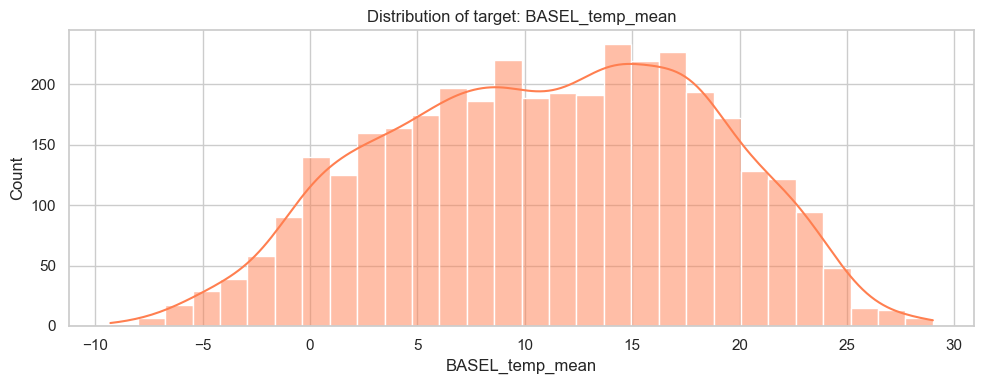

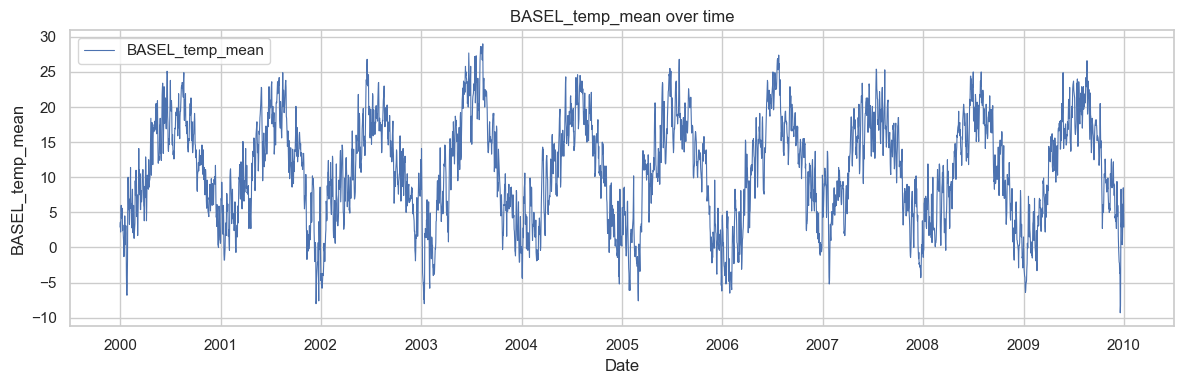

Target (t + 1 days of): BASEL_temp_mean
Train size: 2898, Test size: 725
Sequence shape: (30, 163)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 30, 64)         │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,817 (276.63 KB)

 Trainable params: 70,817 (276.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.3405 - mae: 0.4663 - val_loss: 0.2776 - val_mae: 0.4282
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2122 - mae: 0.3695 - val_loss: 0.2169 - val_mae: 0.3776
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1820 - mae: 0.3395 - val_loss: 0.2220 - val_mae: 0.3809
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1893 - mae: 0.3431 - val_loss: 0.2094 - val_mae: 0.3738
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1572 - mae: 0.3131 - val_loss: 0.2031 - val_mae: 0.3664
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1263 - mae: 0.2816 - val_loss: 0.1751 - val_mae: 0.3360
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1095 - mae: 0.2611 - val_loss: 0.1859 - val_mae: 0.3483
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1016 - mae: 0.2500 - val_loss: 0.1683 - val_mae: 0.3296
Epoch 9/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.119

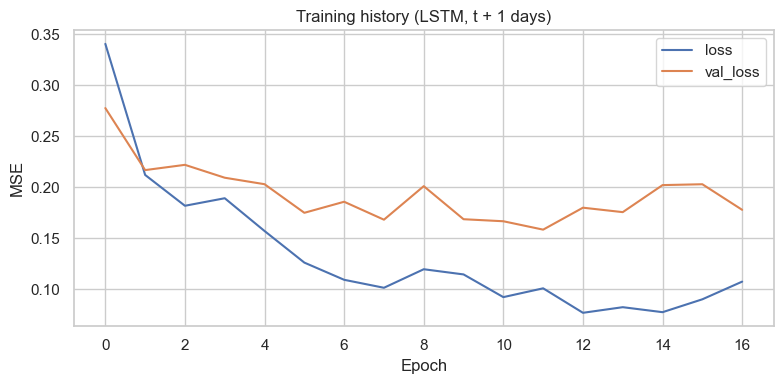

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Results for BASEL_temp_mean at t + 1 days:
  MAE  = 2.284
  RMSE = 2.835
  R^2  = 0.8508


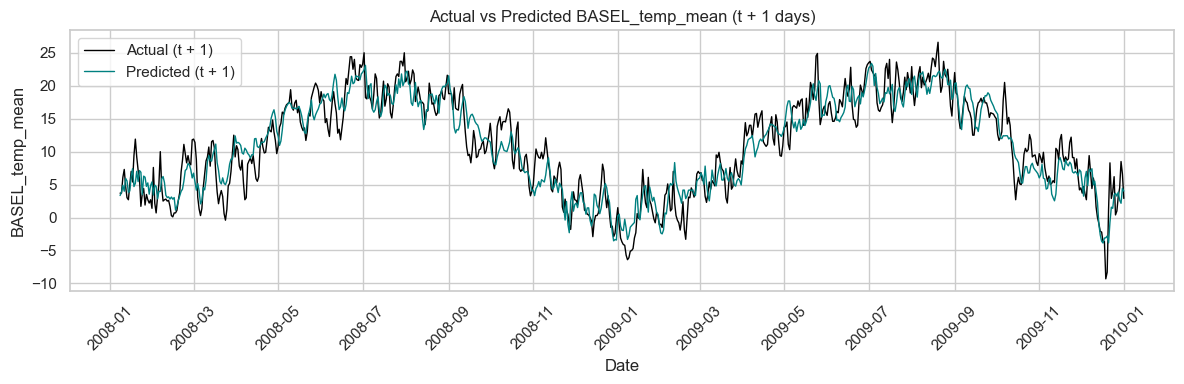

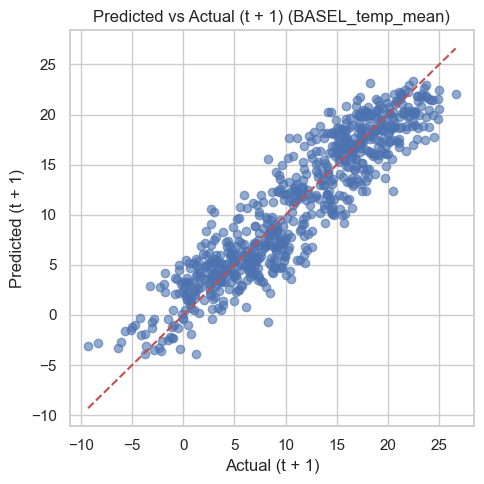

In [27]:
# Basel t+1 (1 day ahead) prediction
results_basel_t1 = run_lstm_for_target_horizon(
    df,
    target_col="BASEL_temp_mean",
    horizon_days=1,
    window=30,
    date_col="DATE"
)

## Basel Temperature Prediction: t+7 (7 days ahead)
Train LSTM model to predict Basel temperature 7 days ahead using 30-day lookback window.

Running LSTM regression for BASEL_temp_mean at t + 7 days


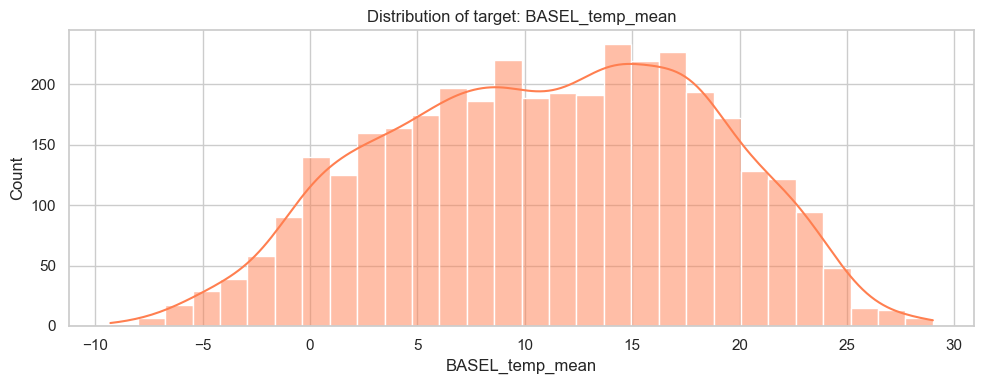

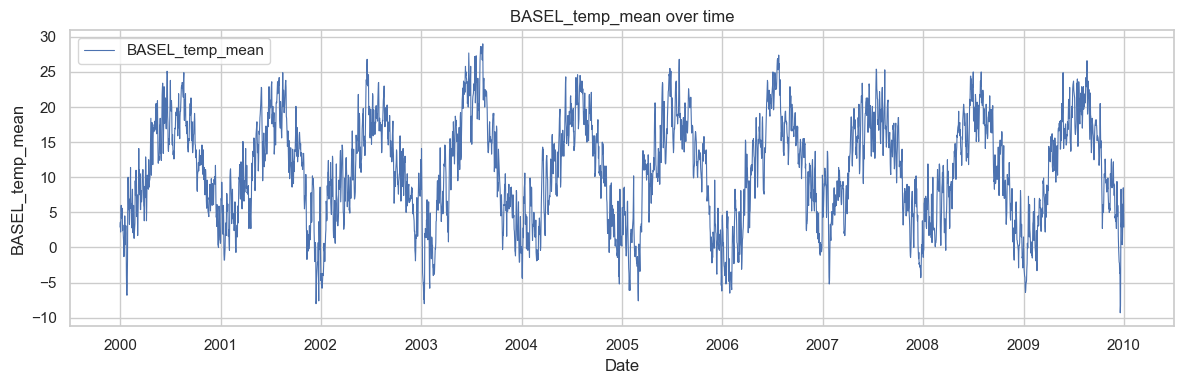

Target (t + 7 days of): BASEL_temp_mean
Train size: 2893, Test size: 724
Sequence shape: (30, 163)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 30, 64)         │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,817 (276.63 KB)

 Trainable params: 70,817 (276.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.3854 - mae: 0.4985 - val_loss: 0.3480 - val_mae: 0.4828
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2834 - mae: 0.4283 - val_loss: 0.3988 - val_mae: 0.5099
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2645 - mae: 0.4103 - val_loss: 0.3591 - val_mae: 0.4930
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2433 - mae: 0.3923 - val_loss: 0.3889 - val_mae: 0.5103
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2374 - mae: 0.3832 - val_loss: 0.3573 - val_mae: 0.4937
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2157 - mae: 0.3664 - val_loss: 0.3376 - val_mae: 0.4783
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1974 - mae: 0.3538 - val_loss: 0.3489 - val_mae: 0.4876
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1855 - mae: 0.3399 - val_loss: 0.3423 - val_mae: 0.4769
Epoch 9/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.168

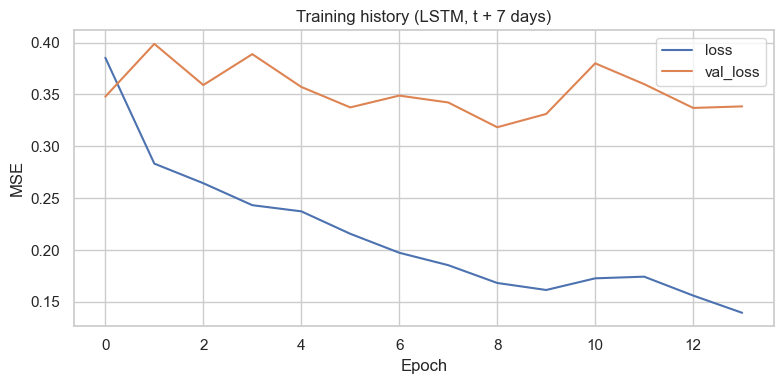

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Results for BASEL_temp_mean at t + 7 days:
  MAE  = 2.940
  RMSE = 3.728
  R^2  = 0.7421


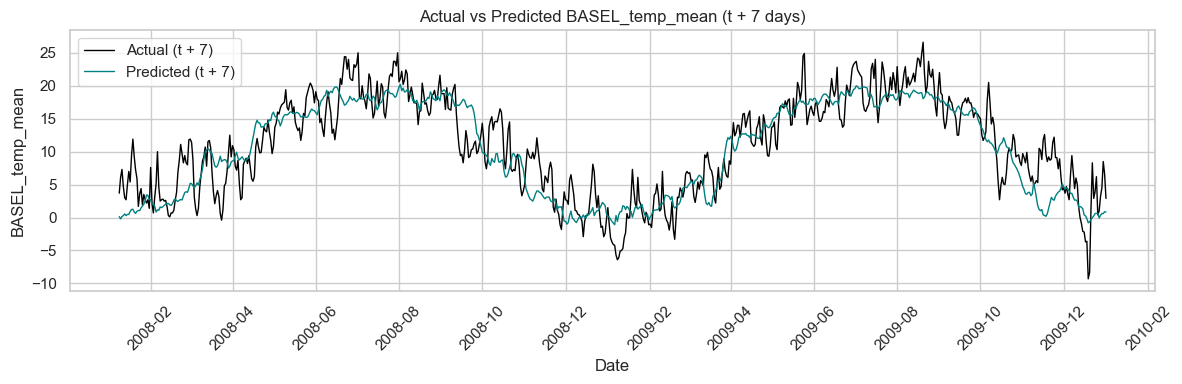

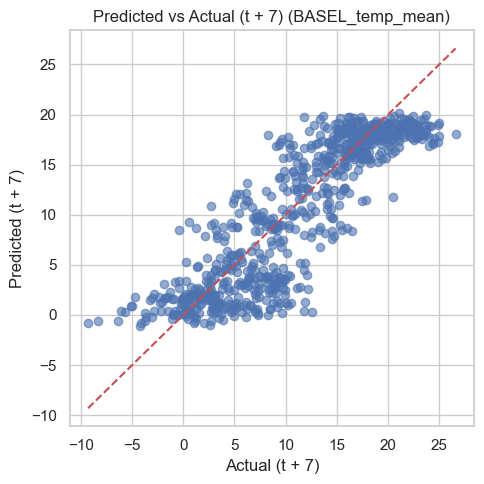

In [28]:
# Basel t+7 (7 days ahead) prediction
results_basel_t7 = run_lstm_for_target_horizon(
    df,
    target_col="BASEL_temp_mean",
    horizon_days=7,
    window=30,
    date_col="DATE"
)

## Comparison: Basel t+1 vs t+7 Predictions
Compare the prediction quality between 1-day ahead and 7-day ahead forecasts for Basel. This shows how prediction accuracy degrades with longer time horizons.

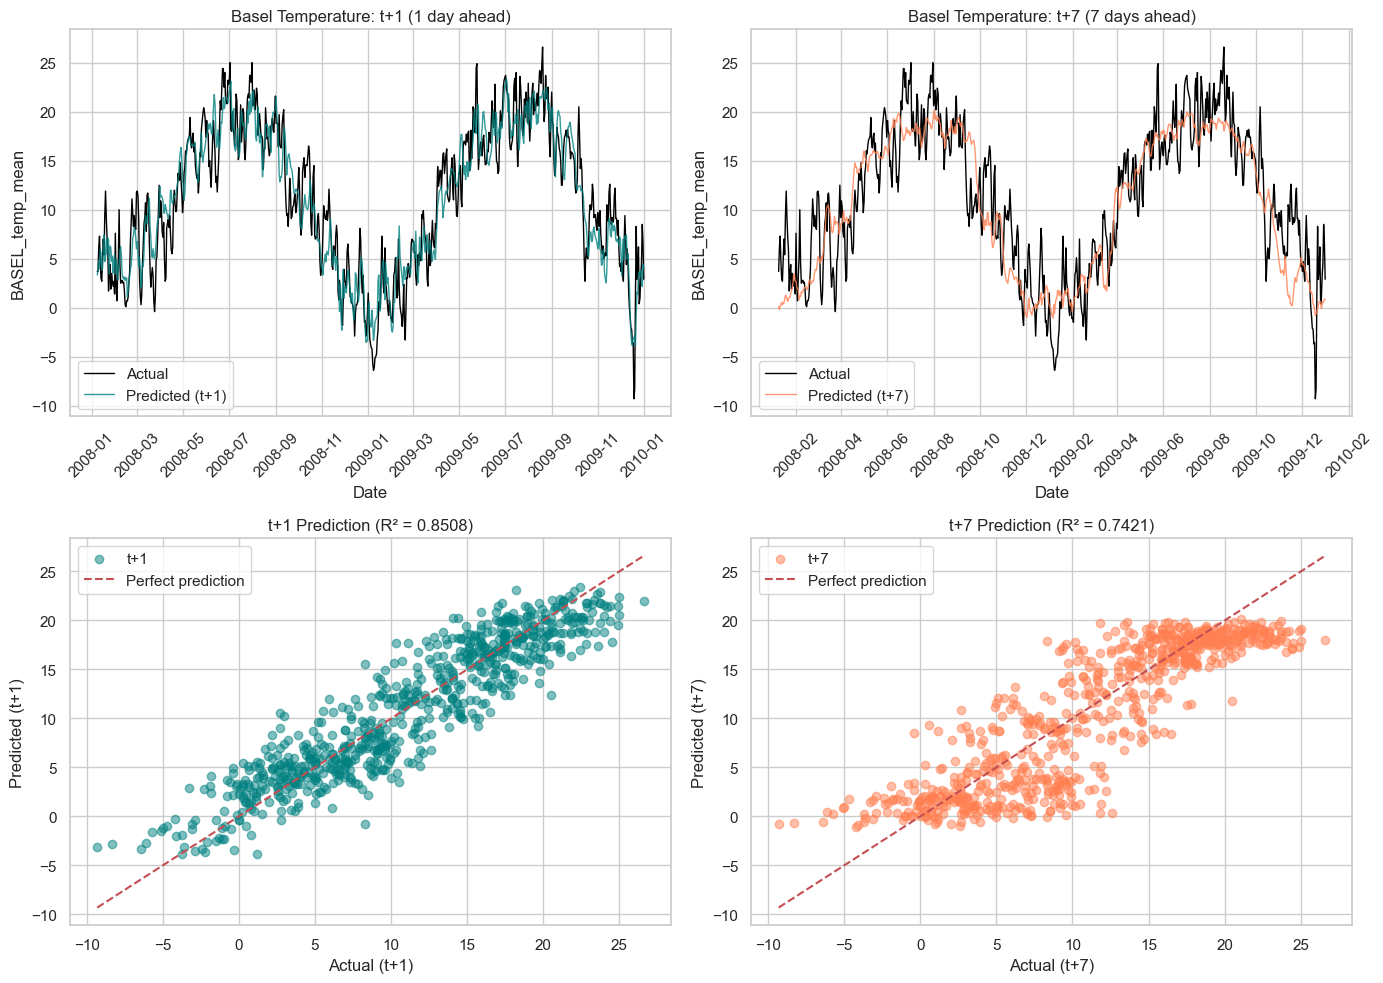


COMPARISON: Basel Temperature Prediction Quality

Metric     t+1 (1 day)     t+7 (7 days)    Difference     
-------------------------------------------------------
MAE        2.284           2.940           +0.656         
RMSE       2.835           3.728           +0.893         
R²         0.8508          0.7421          -0.1087        


In [29]:
# Comparison of Basel predictions at t+1 vs t+7
# Using consistent color scheme: black=Actual, teal=Predicted (t+1), coral=Predicted (t+7)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: t+1 time series
ax1 = axes[0, 0]
ax1.plot(results_basel_t1["date_test"], results_basel_t1["y_test"], 
         label="Actual", color="black", linewidth=1)
ax1.plot(results_basel_t1["date_test"], results_basel_t1["y_pred"], 
         label="Predicted (t+1)", color="teal", linewidth=1, alpha=0.8)
ax1.set_xlabel("Date")
ax1.set_ylabel("BASEL_temp_mean")
ax1.set_title("Basel Temperature: t+1 (1 day ahead)")
# Format dates as year-month (e.g., 2008-10)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
ax1.legend()

# Top right: t+7 time series
ax2 = axes[0, 1]
ax2.plot(results_basel_t7["date_test"], results_basel_t7["y_test"], 
         label="Actual", color="black", linewidth=1)
ax2.plot(results_basel_t7["date_test"], results_basel_t7["y_pred"], 
         label="Predicted (t+7)", color="coral", linewidth=1, alpha=0.8)
ax2.set_xlabel("Date")
ax2.set_ylabel("BASEL_temp_mean")
ax2.set_title("Basel Temperature: t+7 (7 days ahead)")
# Format dates as year-month (e.g., 2008-10)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
ax2.legend()

# Bottom left: t+1 scatter
ax3 = axes[1, 0]
ax3.scatter(results_basel_t1["y_test"], results_basel_t1["y_pred"], 
            alpha=0.5, color="teal", label="t+1")
min_val = min(results_basel_t1["y_test"].min(), results_basel_t1["y_pred"].min())
max_val = max(results_basel_t1["y_test"].max(), results_basel_t1["y_pred"].max())
ax3.plot([min_val, max_val], [min_val, max_val], "r--", label="Perfect prediction")
ax3.set_xlabel("Actual (t+1)")
ax3.set_ylabel("Predicted (t+1)")
ax3.set_title(f"t+1 Prediction (R² = {results_basel_t1['metrics']['R2']:.4f})")
ax3.legend()

# Bottom right: t+7 scatter
ax4 = axes[1, 1]
ax4.scatter(results_basel_t7["y_test"], results_basel_t7["y_pred"], 
            alpha=0.5, color="coral", label="t+7")
min_val = min(results_basel_t7["y_test"].min(), results_basel_t7["y_pred"].min())
max_val = max(results_basel_t7["y_test"].max(), results_basel_t7["y_pred"].max())
ax4.plot([min_val, max_val], [min_val, max_val], "r--", label="Perfect prediction")
ax4.set_xlabel("Actual (t+7)")
ax4.set_ylabel("Predicted (t+7)")
ax4.set_title(f"t+7 Prediction (R² = {results_basel_t7['metrics']['R2']:.4f})")
ax4.legend()

plt.tight_layout()
plt.show()

# Print comparison metrics
print("\n" + "=" * 60)
print("COMPARISON: Basel Temperature Prediction Quality")
print("=" * 60)
print(f"\n{'Metric':<10} {'t+1 (1 day)':<15} {'t+7 (7 days)':<15} {'Difference':<15}")
print("-" * 55)
print(f"{'MAE':<10} {results_basel_t1['metrics']['MAE']:<15.3f} {results_basel_t7['metrics']['MAE']:<15.3f} {results_basel_t7['metrics']['MAE'] - results_basel_t1['metrics']['MAE']:<+15.3f}")
print(f"{'RMSE':<10} {results_basel_t1['metrics']['RMSE']:<15.3f} {results_basel_t7['metrics']['RMSE']:<15.3f} {results_basel_t7['metrics']['RMSE'] - results_basel_t1['metrics']['RMSE']:<+15.3f}")
print(f"{'R²':<10} {results_basel_t1['metrics']['R2']:<15.4f} {results_basel_t7['metrics']['R2']:<15.4f} {results_basel_t7['metrics']['R2'] - results_basel_t1['metrics']['R2']:<+15.4f}")

## Roma Temperature Prediction: t+0 (same day)
Train LSTM model to predict Roma temperature for the same day using 30-day lookback window. This matches the Basel 0-day prediction approach.

In [30]:
# Roma 0-day (same day) prediction - replicate Basel 0-day approach
WINDOW_ROMA = 30  # days of lookback for each prediction
target_col_roma = "ROMA_temp_mean"
date_col_roma = "DATE"

# Work on a copy for Roma
df_work_roma = df.copy()

# Parse and sort by date
if date_col_roma:
    df_work_roma[date_col_roma] = pd.to_datetime(df_work_roma[date_col_roma], errors="coerce")
    df_work_roma = df_work_roma.dropna(subset=[date_col_roma])
    df_work_roma = df_work_roma.sort_values(date_col_roma)
else:
    df_work_roma = df_work_roma.sort_index()

# Ensure target is numeric
if not np.issubdtype(df_work_roma[target_col_roma].dtype, np.number):
    df_work_roma[target_col_roma] = pd.to_numeric(df_work_roma[target_col_roma], errors="coerce")

# Handle missing values
numeric_cols_roma = df_work_roma.select_dtypes(include=[np.number]).columns
categorical_cols_roma = df_work_roma.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
categorical_cols_roma = [c for c in categorical_cols_roma if c != target_col_roma and c != date_col_roma]

df_work_roma[numeric_cols_roma] = df_work_roma[numeric_cols_roma].interpolate(limit_direction="both")
df_work_roma[numeric_cols_roma] = df_work_roma[numeric_cols_roma].fillna(df_work_roma[numeric_cols_roma].median())
for col in categorical_cols_roma:
    df_work_roma[col] = df_work_roma[col].fillna(df_work_roma[col].mode().iloc[0])

# Keep a date index for plotting later
if date_col_roma:
    date_index_roma = df_work_roma[date_col_roma].reset_index(drop=True)
else:
    date_index_roma = pd.RangeIndex(len(df_work_roma))

# Prepare model matrix
model_df_roma = df_work_roma.copy()
if date_col_roma and date_col_roma in model_df_roma.columns:
    model_df_roma = model_df_roma.drop(columns=[date_col_roma])

model_df_roma = pd.get_dummies(model_df_roma, columns=categorical_cols_roma, drop_first=True)
model_df_roma = model_df_roma.dropna(subset=[target_col_roma])

y_roma = model_df_roma[target_col_roma].values
X_roma = model_df_roma.drop(columns=[target_col_roma]).values

feature_scaler_roma = StandardScaler()
X_scaled_roma = feature_scaler_roma.fit_transform(X_roma)

target_scaler_roma = StandardScaler()
y_scaled_roma = target_scaler_roma.fit_transform(y_roma.reshape(-1, 1)).flatten()

# Create sequences
def create_sequences_roma(features: np.ndarray, target: np.ndarray, window: int):
    Xs, ys = [], []
    for i in range(window, len(features)):
        Xs.append(features[i - window : i])
        ys.append(target[i])
    return np.array(Xs), np.array(ys)

X_seq_roma, y_seq_roma = create_sequences_roma(X_scaled_roma, y_scaled_roma, window=WINDOW_ROMA)

split_idx_roma = int(len(X_seq_roma) * 0.8)
X_train_roma, X_test_roma = X_seq_roma[:split_idx_roma], X_seq_roma[split_idx_roma:]
y_train_roma, y_test_roma = y_seq_roma[:split_idx_roma], y_seq_roma[split_idx_roma:]

if date_col_roma:
    date_seq_roma = date_index_roma.iloc[WINDOW_ROMA:].reset_index(drop=True)
else:
    date_seq_roma = pd.RangeIndex(len(y_seq_roma))
date_test_roma = date_seq_roma[split_idx_roma:]

print(f"Roma 0-day prediction setup:")
print(f"Target column: {target_col_roma}")
print(f"Features after encoding: {X_roma.shape[1]}")
print(f"Train sequences: {X_train_roma.shape}, Test sequences: {X_test_roma.shape}")

Roma 0-day prediction setup:
Target column: ROMA_temp_mean
Features after encoding: 163
Train sequences: (2899, 30, 163), Test sequences: (725, 30, 163)


Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1374 - mae: 0.2725 - val_loss: 0.1062 - val_mae: 0.2463
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0599 - mae: 0.1864 - val_loss: 0.0952 - val_mae: 0.2349
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0491 - mae: 0.1691 - val_loss: 0.0889 - val_mae: 0.2285
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0426 - mae: 0.1576 - val_loss: 0.0931 - val_mae: 0.2361
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0380 - mae: 0.1491 - val_loss: 0.0867 - val_mae: 0.2288
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0359 - mae: 0.1440 - val_loss: 0.0842 - val_mae: 0.2246
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0323 - mae: 0.1361 - val_loss: 0.0876 - val_mae: 0.2306
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0308 - mae: 0.1350 - val_loss: 0.0882 - val_mae: 0.2332
Epoch 9/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.029

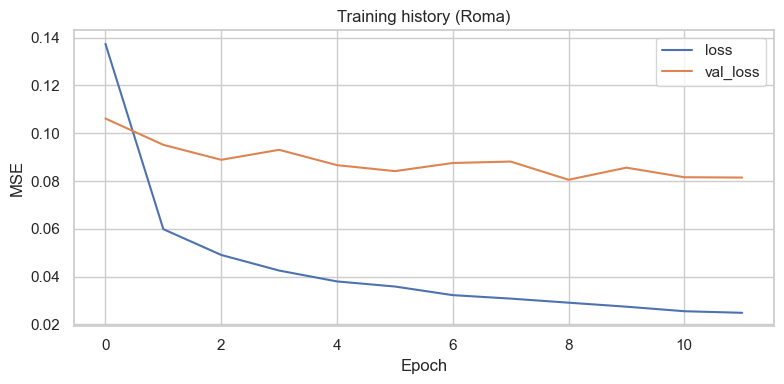

In [31]:
# Build and train LSTM model for Roma
model_roma = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X_train_roma.shape[1:]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

model_roma.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="mse",
              metrics=["mae"])

callbacks_roma = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
]

history_roma = model_roma.fit(
    X_train_roma,
    y_train_roma,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=callbacks_roma,
    verbose=1
)

history_df_roma = pd.DataFrame(history_roma.history)
plt.figure(figsize=(8, 4))
plt.plot(history_df_roma["loss"], label="loss")
plt.plot(history_df_roma["val_loss"], label="val_loss")
plt.title("Training history (Roma)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Results for ROMA_temp_mean:
  MAE  = 1.480
  RMSE = 1.898
  R^2  = 0.9273


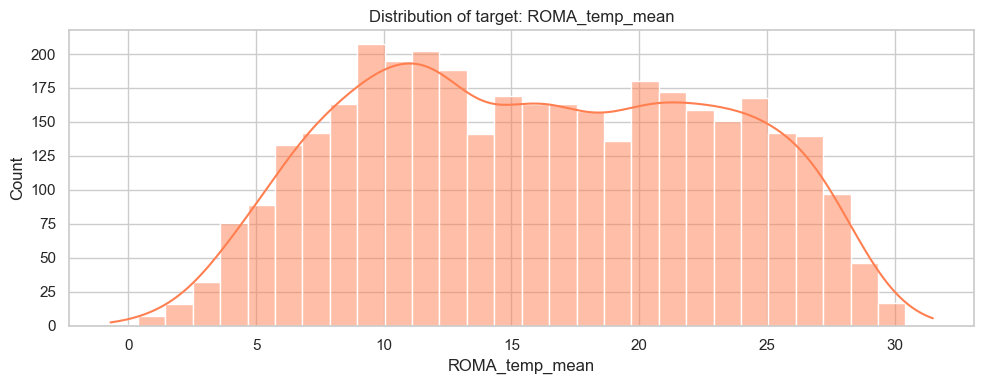

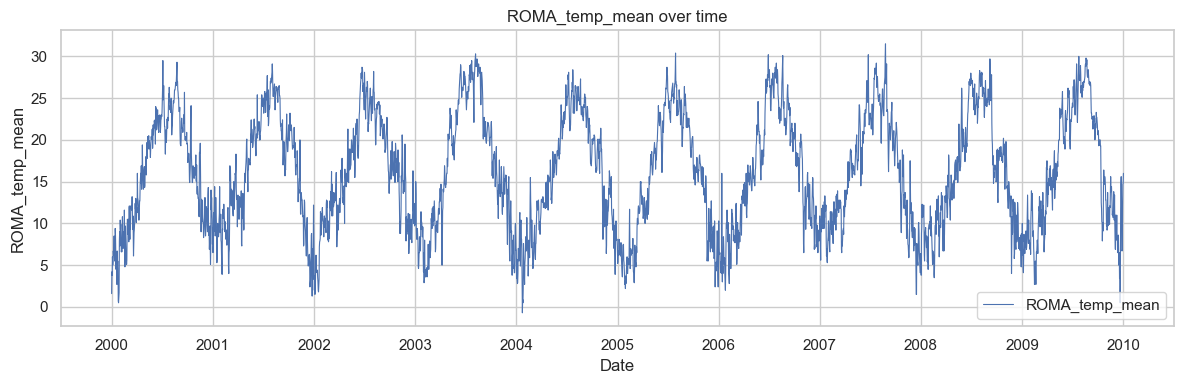

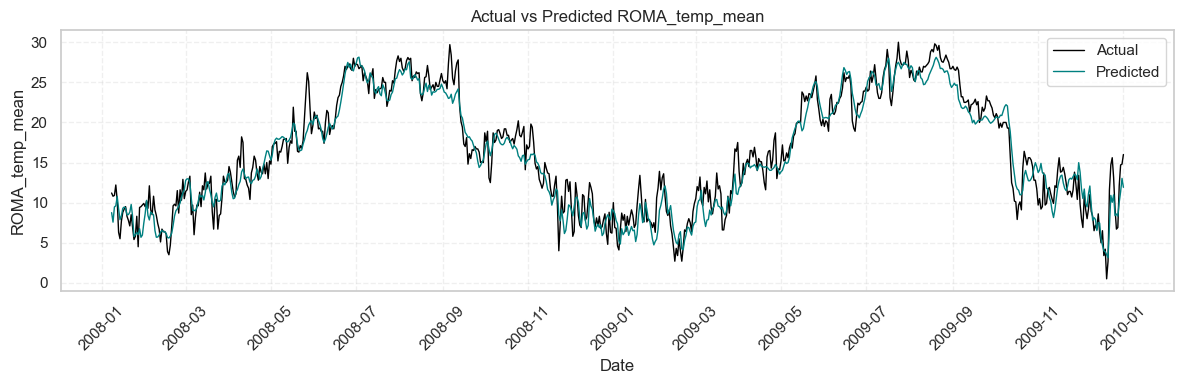

In [32]:
# Predict on the hold-out set and invert scaling for Roma
y_pred_scaled_roma = model_roma.predict(X_test_roma)
y_pred_roma = target_scaler_roma.inverse_transform(y_pred_scaled_roma).flatten()
y_true_roma = target_scaler_roma.inverse_transform(y_test_roma.reshape(-1, 1)).flatten()

mae_roma = mean_absolute_error(y_true_roma, y_pred_roma)
try:
    rmse_roma = mean_squared_error(y_true_roma, y_pred_roma, squared=False)
except TypeError:  # compatibility with older scikit-learn
    rmse_roma = np.sqrt(mean_squared_error(y_true_roma, y_pred_roma))
r2_roma = r2_score(y_true_roma, y_pred_roma)

print(f"\nResults for {target_col_roma}:")
print(f"  MAE  = {mae_roma:.3f}")
print(f"  RMSE = {rmse_roma:.3f}")
print(f"  R^2  = {r2_roma:.4f}")

# Time series plot with proper date formatting
plt.figure(figsize=(10, 4))
sns.histplot(df[target_col_roma], bins=30, kde=True, color="coral")
plt.title(f"Distribution of target: {target_col_roma}")
plt.xlabel(target_col_roma)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Time series with proper date formatting
fig, ax = plt.subplots(figsize=(12, 4))
if date_col_roma in df.columns:
    date_vals_roma = pd.to_datetime(df[date_col_roma], format="%Y%m%d", errors="coerce")
    ax.plot(date_vals_roma, df[target_col_roma], label=target_col_roma, linewidth=0.8)
    ax.set_xlabel("Date")
    # Format dates as year (e.g., 2008)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=6))
else:
    ax.plot(df[target_col_roma].reset_index(drop=True), label=target_col_roma, linewidth=0.8)
    ax.set_xlabel("Observation index")
ax.set_ylabel(target_col_roma)
ax.set_title(f"{target_col_roma} over time")
ax.legend()
plt.tight_layout()
plt.show()

# Actual vs Predicted ROMA_temp_mean
fig, ax = plt.subplots(figsize=(12, 4))
# Reconstruct test_dates from original dataframe using same approach as plot above
if date_col_roma:
    # Get the test set dates: start from WINDOW_ROMA + split_idx_roma in the original df
    test_start_idx_roma = WINDOW_ROMA + split_idx_roma
    test_end_idx_roma = test_start_idx_roma + len(y_true_roma)
    test_dates_roma = pd.to_datetime(df[date_col_roma].iloc[test_start_idx_roma:test_end_idx_roma], format="%Y%m%d", errors="coerce").reset_index(drop=True)
else:
    test_dates_roma = pd.RangeIndex(len(y_true_roma))
ax.plot(test_dates_roma, y_true_roma, label="Actual", color="black", linewidth=1)
ax.plot(test_dates_roma, y_pred_roma, label="Predicted", color="teal", linewidth=1)
ax.set_title(f"Actual vs Predicted {target_col_roma}")
ax.set_xlabel("Date")
ax.set_ylabel(target_col_roma)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.grid(alpha=0.3, linestyle="--")
ax.legend()
plt.tight_layout()
plt.show()

## Roma Temperature Predictions (t+1 and t+7)
Additional predictions for Roma to match the FFNN notebook's city coverage.

Running LSTM regression for ROMA_temp_mean at t + 1 days


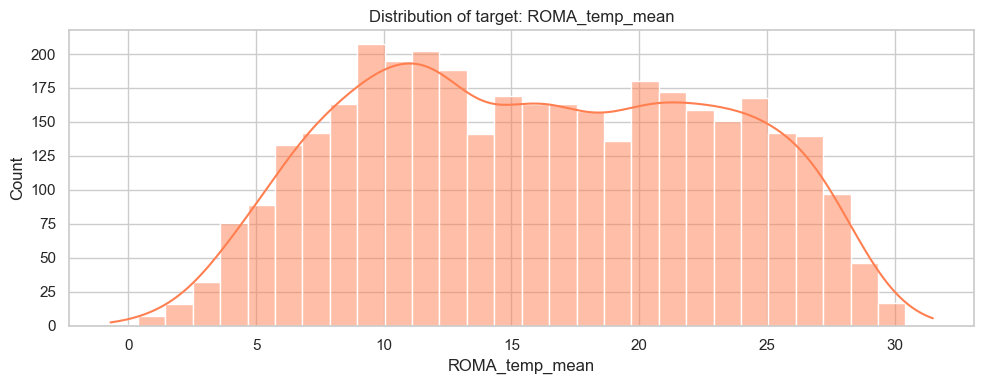

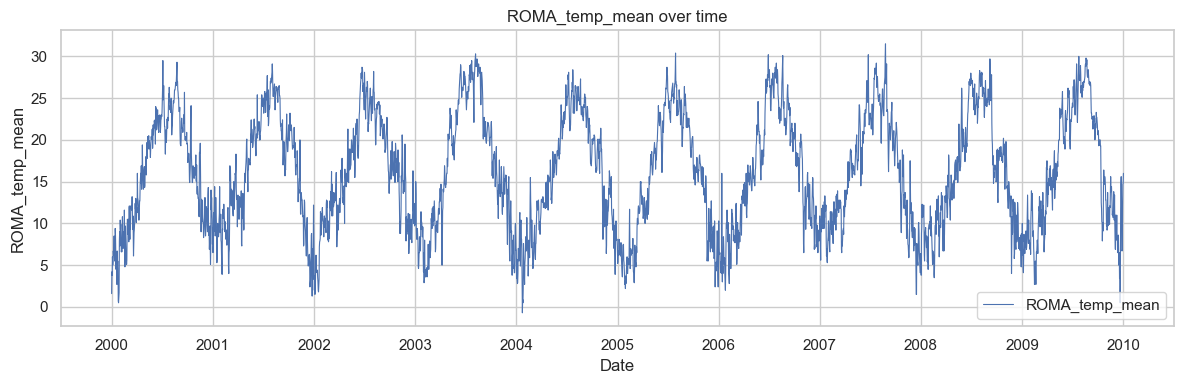

Target (t + 1 days of): ROMA_temp_mean
Train size: 2898, Test size: 725
Sequence shape: (30, 163)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 30, 64)         │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,817 (276.63 KB)

 Trainable params: 70,817 (276.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2473 - mae: 0.3923 - val_loss: 0.1581 - val_mae: 0.3110
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1353 - mae: 0.2922 - val_loss: 0.1336 - val_mae: 0.2823
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0873 - mae: 0.2287 - val_loss: 0.1099 - val_mae: 0.2572
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0720 - mae: 0.2078 - val_loss: 0.1231 - val_mae: 0.2718
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0851 - mae: 0.2167 - val_loss: 0.1799 - val_mae: 0.3303
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0896 - mae: 0.2283 - val_loss: 0.1186 - val_mae: 0.2672
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0800 - mae: 0.2177 - val_loss: 0.1142 - val_mae: 0.2667
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0792 - mae: 0.2213 - val_loss: 0.1012 - val_mae: 0.2463
Epoch 9/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.070

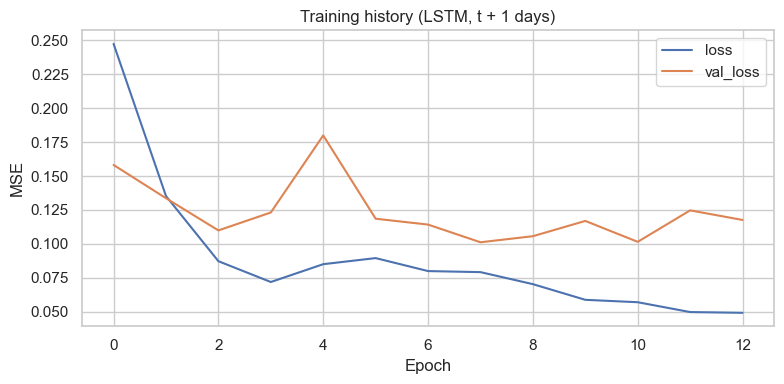

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Results for ROMA_temp_mean at t + 1 days:
  MAE  = 1.834
  RMSE = 2.332
  R^2  = 0.8903


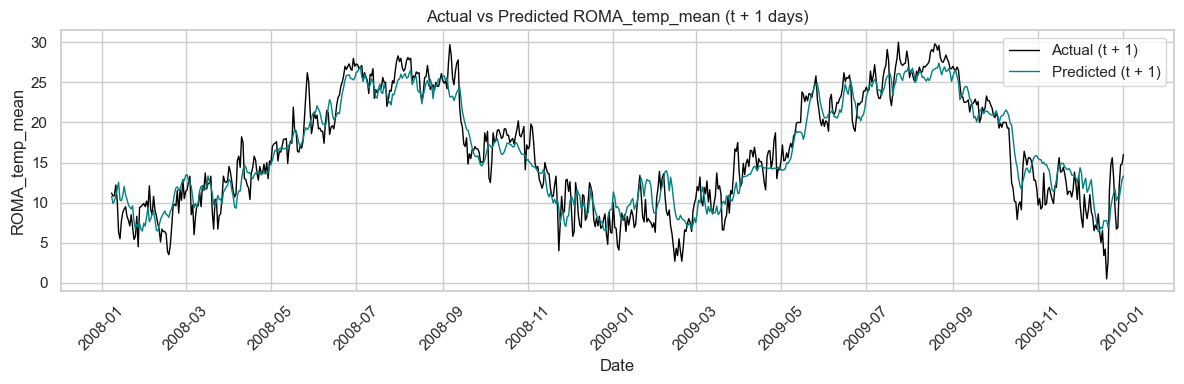

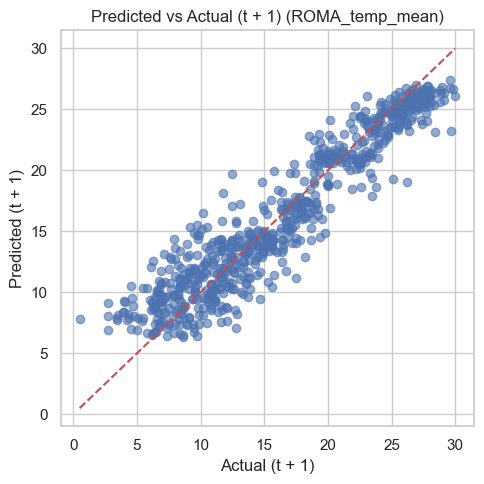

In [33]:
# Roma t+1 (1 day ahead) prediction
results_roma_t1 = run_lstm_for_target_horizon(
    df,
    target_col="ROMA_temp_mean",
    horizon_days=1,
    window=30,
    date_col="DATE"
)

Running LSTM regression for ROMA_temp_mean at t + 7 days


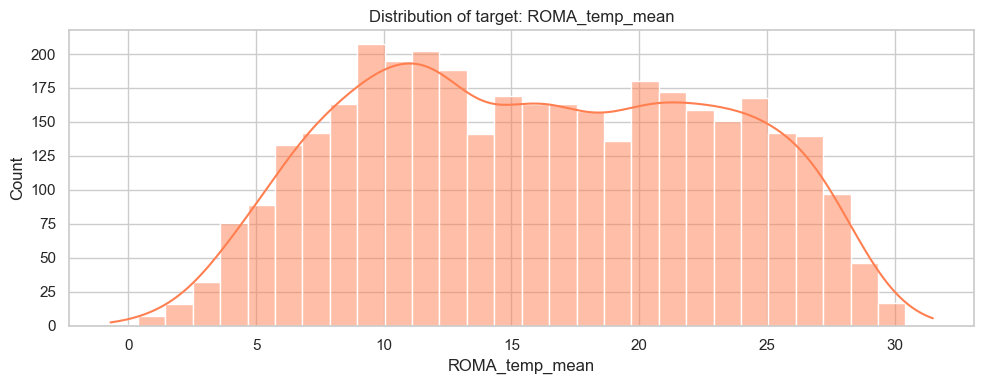

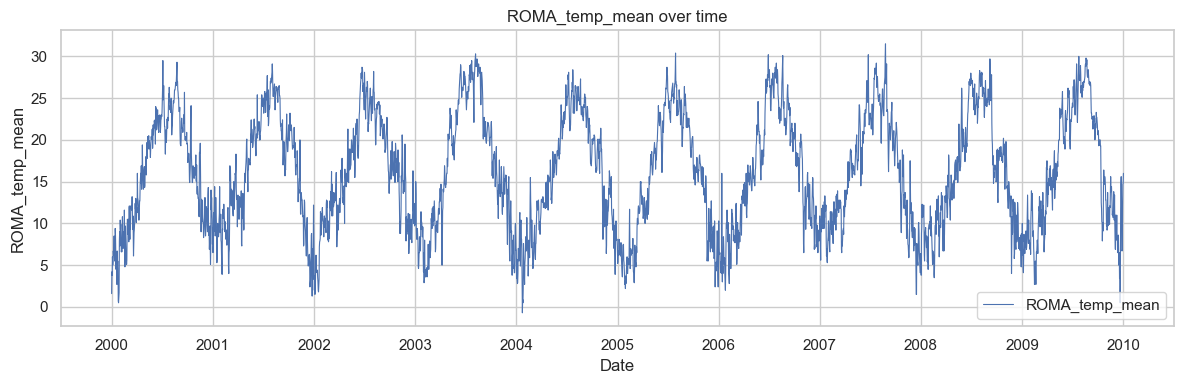

Target (t + 7 days of): ROMA_temp_mean
Train size: 2893, Test size: 724
Sequence shape: (30, 163)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 30, 64)         │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,817 (276.63 KB)

 Trainable params: 70,817 (276.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.2495 - mae: 0.3976 - val_loss: 0.2064 - val_mae: 0.3638
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1665 - mae: 0.3287 - val_loss: 0.1729 - val_mae: 0.3342
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1354 - mae: 0.2895 - val_loss: 0.1740 - val_mae: 0.3305
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1206 - mae: 0.2696 - val_loss: 0.1658 - val_mae: 0.3262
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1182 - mae: 0.2686 - val_loss: 0.1704 - val_mae: 0.3277
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0980 - mae: 0.2442 - val_loss: 0.1647 - val_mae: 0.3262
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1078 - mae: 0.2544 - val_loss: 0.1687 - val_mae: 0.3285
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0901 - mae: 0.2349 - val_loss: 0.1691 - val_mae: 0.3276
Epoch 9/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.080

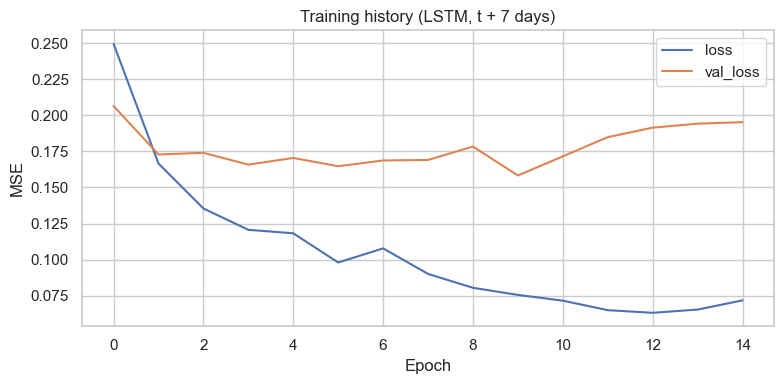

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Results for ROMA_temp_mean at t + 7 days:
  MAE  = 2.221
  RMSE = 2.750
  R^2  = 0.8475


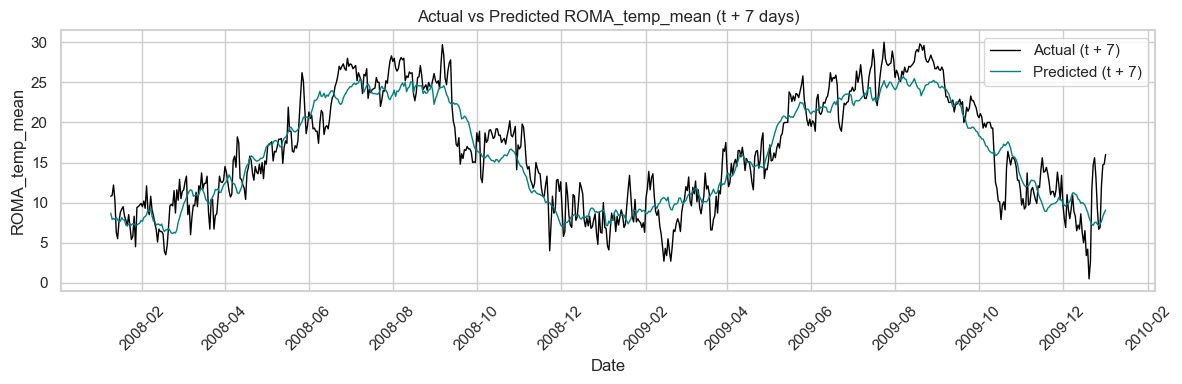

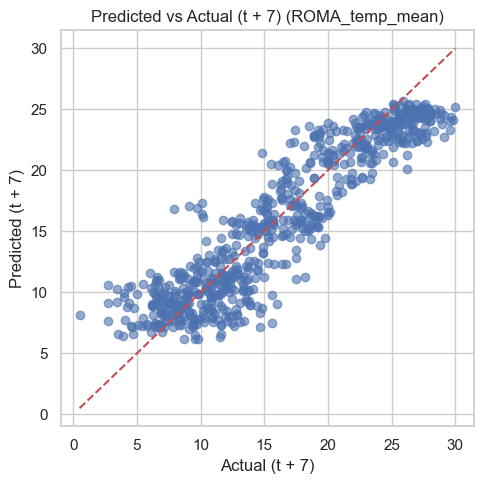

In [34]:
# Roma t+7 (7 days ahead) prediction
results_roma_t7 = run_lstm_for_target_horizon(
    df,
    target_col="ROMA_temp_mean",
    horizon_days=7,
    window=30,
    date_col="DATE"
)

## Comparison: Roma t+1 vs t+7 Predictions
Compare how the Roma forecasts degrade from 1-day to 7-day ahead horizons using the same layout as the Basel comparison.

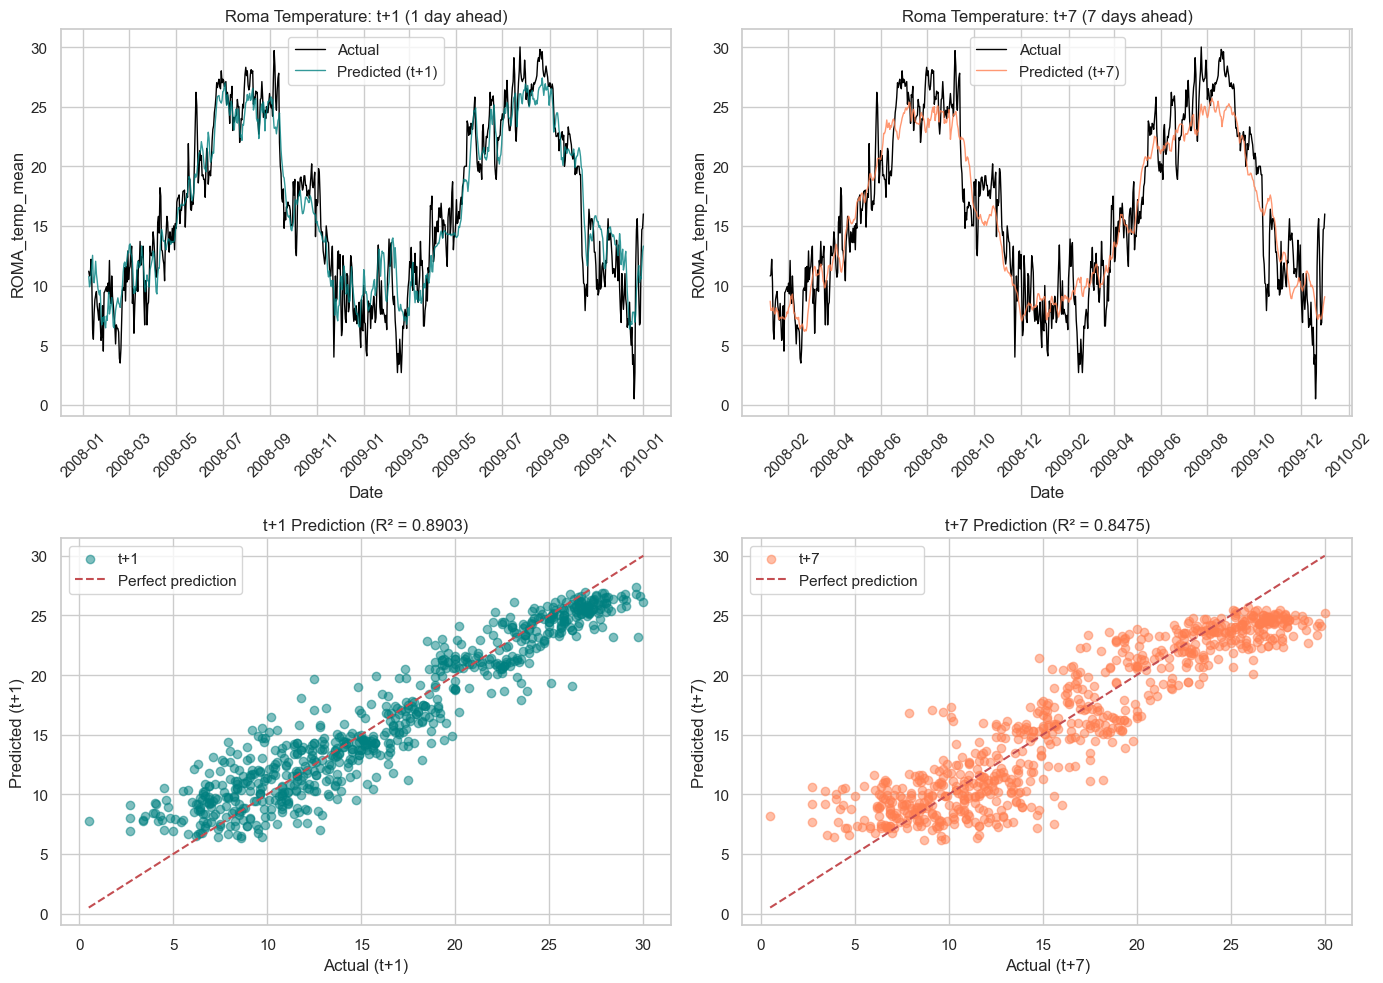


COMPARISON: Roma Temperature Prediction Quality

Metric     t+1 (1 day)     t+7 (7 days)    Difference     
-------------------------------------------------------
MAE        1.834           2.221           +0.387         
RMSE       2.332           2.750           +0.418         
R²         0.8903          0.8475          -0.0428        


In [35]:
# Comparison of Roma predictions at t+1 vs t+7
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: t+1 time series
ax1 = axes[0, 0]
ax1.plot(results_roma_t1["date_test"], results_roma_t1["y_test"], 
         label="Actual", color="black", linewidth=1)
ax1.plot(results_roma_t1["date_test"], results_roma_t1["y_pred"], 
         label="Predicted (t+1)", color="teal", linewidth=1, alpha=0.8)
ax1.set_xlabel("Date")
ax1.set_ylabel("ROMA_temp_mean")
ax1.set_title("Roma Temperature: t+1 (1 day ahead)")
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
ax1.legend()

# Top right: t+7 time series
ax2 = axes[0, 1]
ax2.plot(results_roma_t7["date_test"], results_roma_t7["y_test"], 
         label="Actual", color="black", linewidth=1)
ax2.plot(results_roma_t7["date_test"], results_roma_t7["y_pred"], 
         label="Predicted (t+7)", color="coral", linewidth=1, alpha=0.8)
ax2.set_xlabel("Date")
ax2.set_ylabel("ROMA_temp_mean")
ax2.set_title("Roma Temperature: t+7 (7 days ahead)")
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
ax2.legend()

# Bottom left: t+1 scatter
ax3 = axes[1, 0]
ax3.scatter(results_roma_t1["y_test"], results_roma_t1["y_pred"], 
            alpha=0.5, color="teal", label="t+1")
min_val = min(results_roma_t1["y_test"].min(), results_roma_t1["y_pred"].min())
max_val = max(results_roma_t1["y_test"].max(), results_roma_t1["y_pred"].max())
ax3.plot([min_val, max_val], [min_val, max_val], "r--", label="Perfect prediction")
ax3.set_xlabel("Actual (t+1)")
ax3.set_ylabel("Predicted (t+1)")
ax3.set_title(f"t+1 Prediction (R² = {results_roma_t1['metrics']['R2']:.4f})")
ax3.legend()

# Bottom right: t+7 scatter
ax4 = axes[1, 1]
ax4.scatter(results_roma_t7["y_test"], results_roma_t7["y_pred"], 
            alpha=0.5, color="coral", label="t+7")
min_val = min(results_roma_t7["y_test"].min(), results_roma_t7["y_pred"].min())
max_val = max(results_roma_t7["y_test"].max(), results_roma_t7["y_pred"].max())
ax4.plot([min_val, max_val], [min_val, max_val], "r--", label="Perfect prediction")
ax4.set_xlabel("Actual (t+7)")
ax4.set_ylabel("Predicted (t+7)")
ax4.set_title(f"t+7 Prediction (R² = {results_roma_t7['metrics']['R2']:.4f})")
ax4.legend()

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("COMPARISON: Roma Temperature Prediction Quality")
print("=" * 60)
print(f"\n{'Metric':<10} {'t+1 (1 day)':<15} {'t+7 (7 days)':<15} {'Difference':<15}")
print("-" * 55)
print(f"{'MAE':<10} {results_roma_t1['metrics']['MAE']:<15.3f} {results_roma_t7['metrics']['MAE']:<15.3f} {results_roma_t7['metrics']['MAE'] - results_roma_t1['metrics']['MAE']:<+15.3f}")
print(f"{'RMSE':<10} {results_roma_t1['metrics']['RMSE']:<15.3f} {results_roma_t7['metrics']['RMSE']:<15.3f} {results_roma_t7['metrics']['RMSE'] - results_roma_t1['metrics']['RMSE']:<+15.3f}")
print(f"{'R²':<10} {results_roma_t1['metrics']['R2']:<15.4f} {results_roma_t7['metrics']['R2']:<15.4f} {results_roma_t7['metrics']['R2'] - results_roma_t1['metrics']['R2']:<+15.4f}")

## Summary: LSTM Model Performance
Summary of all LSTM prediction results showing how prediction quality varies by city and time horizon.

In [36]:
# Summary table of all LSTM results
summary_data = {
    "City": ["Basel", "Basel", "Roma", "Roma"],
    "Horizon": ["t+1 (1 day)", "t+7 (7 days)", "t+1 (1 day)", "t+7 (7 days)"],
    "MAE": [
        results_basel_t1["metrics"]["MAE"],
        results_basel_t7["metrics"]["MAE"],
        results_roma_t1["metrics"]["MAE"],
        results_roma_t7["metrics"]["MAE"],
    ],
    "RMSE": [
        results_basel_t1["metrics"]["RMSE"],
        results_basel_t7["metrics"]["RMSE"],
        results_roma_t1["metrics"]["RMSE"],
        results_roma_t7["metrics"]["RMSE"],
    ],
    "R²": [
        results_basel_t1["metrics"]["R2"],
        results_basel_t7["metrics"]["R2"],
        results_roma_t1["metrics"]["R2"],
        results_roma_t7["metrics"]["R2"],
    ],
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "=" * 70)
print("LSTM MODEL PERFORMANCE SUMMARY")
print("=" * 70)
display(summary_df.style.format({"MAE": "{:.3f}", "RMSE": "{:.3f}", "R²": "{:.4f}"}))

# Key observations
print("\nKey Observations:")
print("-" * 50)
print("1. Prediction accuracy decreases with longer time horizons for both Basel and Roma")
print(f"   - Basel t+1 R²: {results_basel_t1['metrics']['R2']:.4f}")
print(f"   - Basel t+7 R²: {results_basel_t7['metrics']['R2']:.4f}")
print(f"   - Roma t+1 R²: {results_roma_t1['metrics']['R2']:.4f}")
print(f"   - Roma t+7 R²: {results_roma_t7['metrics']['R2']:.4f}")
print("\n2. The LSTM model captures temporal patterns in weather data")
print("   using a 30-day lookback window for sequence modeling.")


LSTM MODEL PERFORMANCE SUMMARY


,City,Horizon,MAE,RMSE,R²
0,Basel,t+1 (1 day),2.284,2.835,0.8508
1,Basel,t+7 (7 days),2.940,3.728,0.7421
2,Roma,t+1 (1 day),1.834,2.332,0.8903
3,Roma,t+7 (7 days),2.221,2.750,0.8475



Key Observations:
--------------------------------------------------
1. Prediction accuracy decreases with longer time horizons for both Basel and Roma
   - Basel t+1 R²: 0.8508
   - Basel t+7 R²: 0.7421
   - Roma t+1 R²: 0.8903
   - Roma t+7 R²: 0.8475

2. The LSTM model captures temporal patterns in weather data
   using a 30-day lookback window for sequence modeling.
